In [1]:
import pathlib
import numpy as np

from fytok.Tokamak import Tokamak
from spdm.view import View as sp_view

data_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")

2023-12-16 13:25:42,108 [    spdm]     INFO: 
###################################################################################################

    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = alpha  (spdm=beta extension=0.2.2.dev19+g14adade.d20231205, imas_version=v3_38_1_dirty)

 Run by salmon at 2023-12-16T13:25:41.771792.
 Job ID: fytok_salmon_surface_24080

###################################################################################################



In [14]:
tokamak = Tokamak(
    f"file+iterprofiles://{next(data_path.glob('*ASTRA.xls')).absolute().as_posix()}",
    f"file+geqdsk://{next(data_path.glob('**/g*.txt')).absolute().as_posix()}",
    device="iter",
    shot=900003,
    equilibrium={"code": {"parameters": {"psi_norm": np.linspace(0.01, 0.996, 64)}}},
    core_transport={
        "model": [
            {"code": {"name": "dummy"}},
            # {"code": {"name": "fast_alpha"}},
        ]
    },
    core_sources={
        "source": [
            {"code": {"name": "dummy"}},
            # {"code": {"name": "fusion_reaction"}},
            # {"code": {"name": "collisional_equipartition"}},
        ]
    },
    transport_solver={
        "code": {
            "name": "fy_trans",
            "parameters": {
                "rho_tor_norm": np.linspace(0.01, 1.0, 128),
                "bvp_rms_mask": [0.96],
                "hyper_diff": 0.0001,
                "max_nodes": 512,
                "verbose": 2,
            },
        },
        "species": ["D", "T"],
        "impurity": ["Ar", "Be"],
        "boundary_condition_type": {
            # fmt: off
            "*/density"                 : (2, 1),
            "*/temperature"             : (2, 1),
          
            "electrons/temperature"     : (2, 1),
            # fmt: on
        },
    },
)

In [15]:
tokamak.transport_solver.refresh(
    time=0.0,
    # fmt:off
    initial_value={
        "ion/D/density":            1.0e19,
        "ion/T/density":            1.0e19,
        "ion/He/density":           0.1e19,
        "ion/alpha/density":        0.0,

        "ion/D/temperature":        1000,
        "ion/T/temperature":        1000,
        "ion/He/temperature":       1000,

        "electrons/temperature":    1000,
    },
    boundary_value={
        "ion/D/density":            ([0.0], [1.3e19]), 
        "ion/T/density":            ([0.0], [1.3e19]), 
        "ion/He/density":           ([0.0], [1.0e16]), 
        "ion/alpha/density":        ([0.0], [2.0e18]), 

        "ion/D/temperature":        ([0.0], [200]),   
        "ion/T/temperature":        ([0.0], [200]),   
        "ion/He/temperature":       ([0.0], [200]),   
        "electrons/temperature":    ([0.0], [200]),   
    },
    # fmt:on
)

2023-12-16 13:27:38,766 [    spdm]     INFO: Initialize module fytok.modules.Wall 
2023-12-16 13:27:38,772 [    spdm]     INFO: Initialize module fytok.modules.TF 
2023-12-16 13:27:38,778 [    spdm]     INFO: Initialize module fytok.modules.Magnetics 
2023-12-16 13:27:38,782 [    spdm]     INFO: Initialize module fytok.modules.PFActive 
2023-12-16 13:27:38,786 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.fy_eq [fytok] 
2023-12-16 13:27:38,798 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 
2023-12-16 13:27:38,801 [    spdm]     INFO: Initialize module fytok.modules.CoreTransport 
2023-12-16 13:27:38,809 [    spdm]     INFO: Initialize module fytok.modules.CoreSources 
2023-12-16 13:27:38,814 [    spdm]     INFO: Initialize module fytok.plugins.transport_solver_numerics.fy_trans [fytok] 
2023-12-16 13:27:39,246 [    spdm]    DEBUG: /home/salmon/workspace/fytok/python/fytok/modules/TransportSolverNumerics.py:310:preprocess:  Variables : ['ion/D/dens

In [16]:
solver_1d = tokamak.transport_solver.time_slice.current

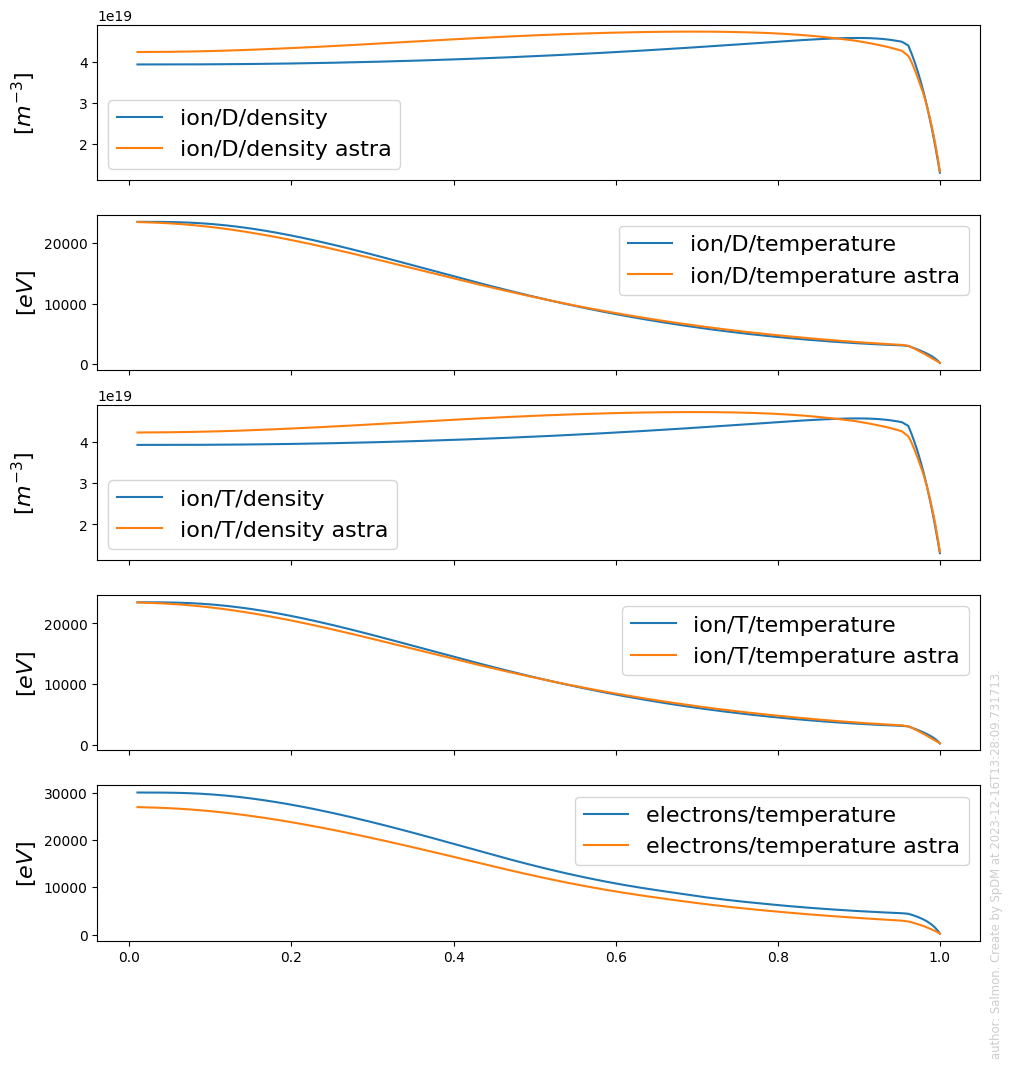

In [17]:
core_profiles_1d = tokamak.transport_solver.fetch()
core_profiles_1d_astra = tokamak.core_profiles.time_slice.current.profiles_1d
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    *[
        [
            (core_profiles_1d.get(equ.identifier), rf"{equ.identifier} "),
            (core_profiles_1d_astra.get(equ.identifier, 0), rf"{equ.identifier} astra"),
        ]
        for equ in solver_1d.equations
    ],
)

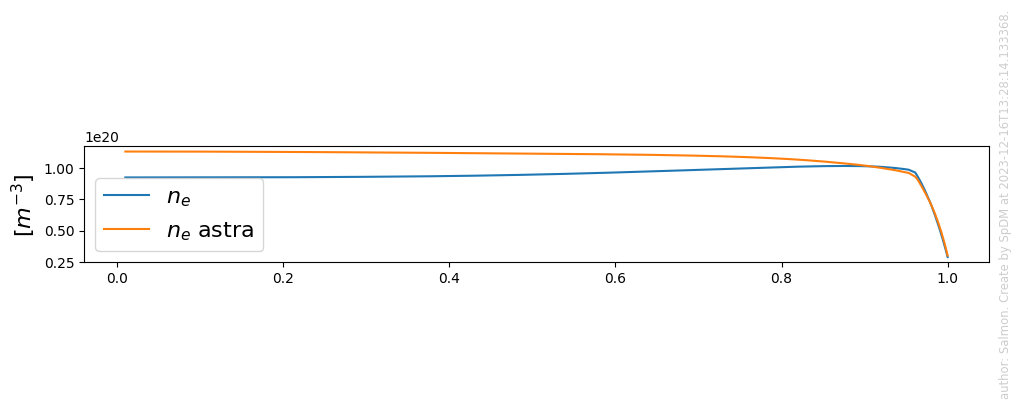

In [18]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [
        (core_profiles_1d.electrons.density, r"$n_{e}$"),
        (core_profiles_1d_astra.electrons.density, r"$n_{e}$ astra"),
    ],
)

In [7]:
core_profiles_1d.get("ion/T/temperature")[-1]

200.0

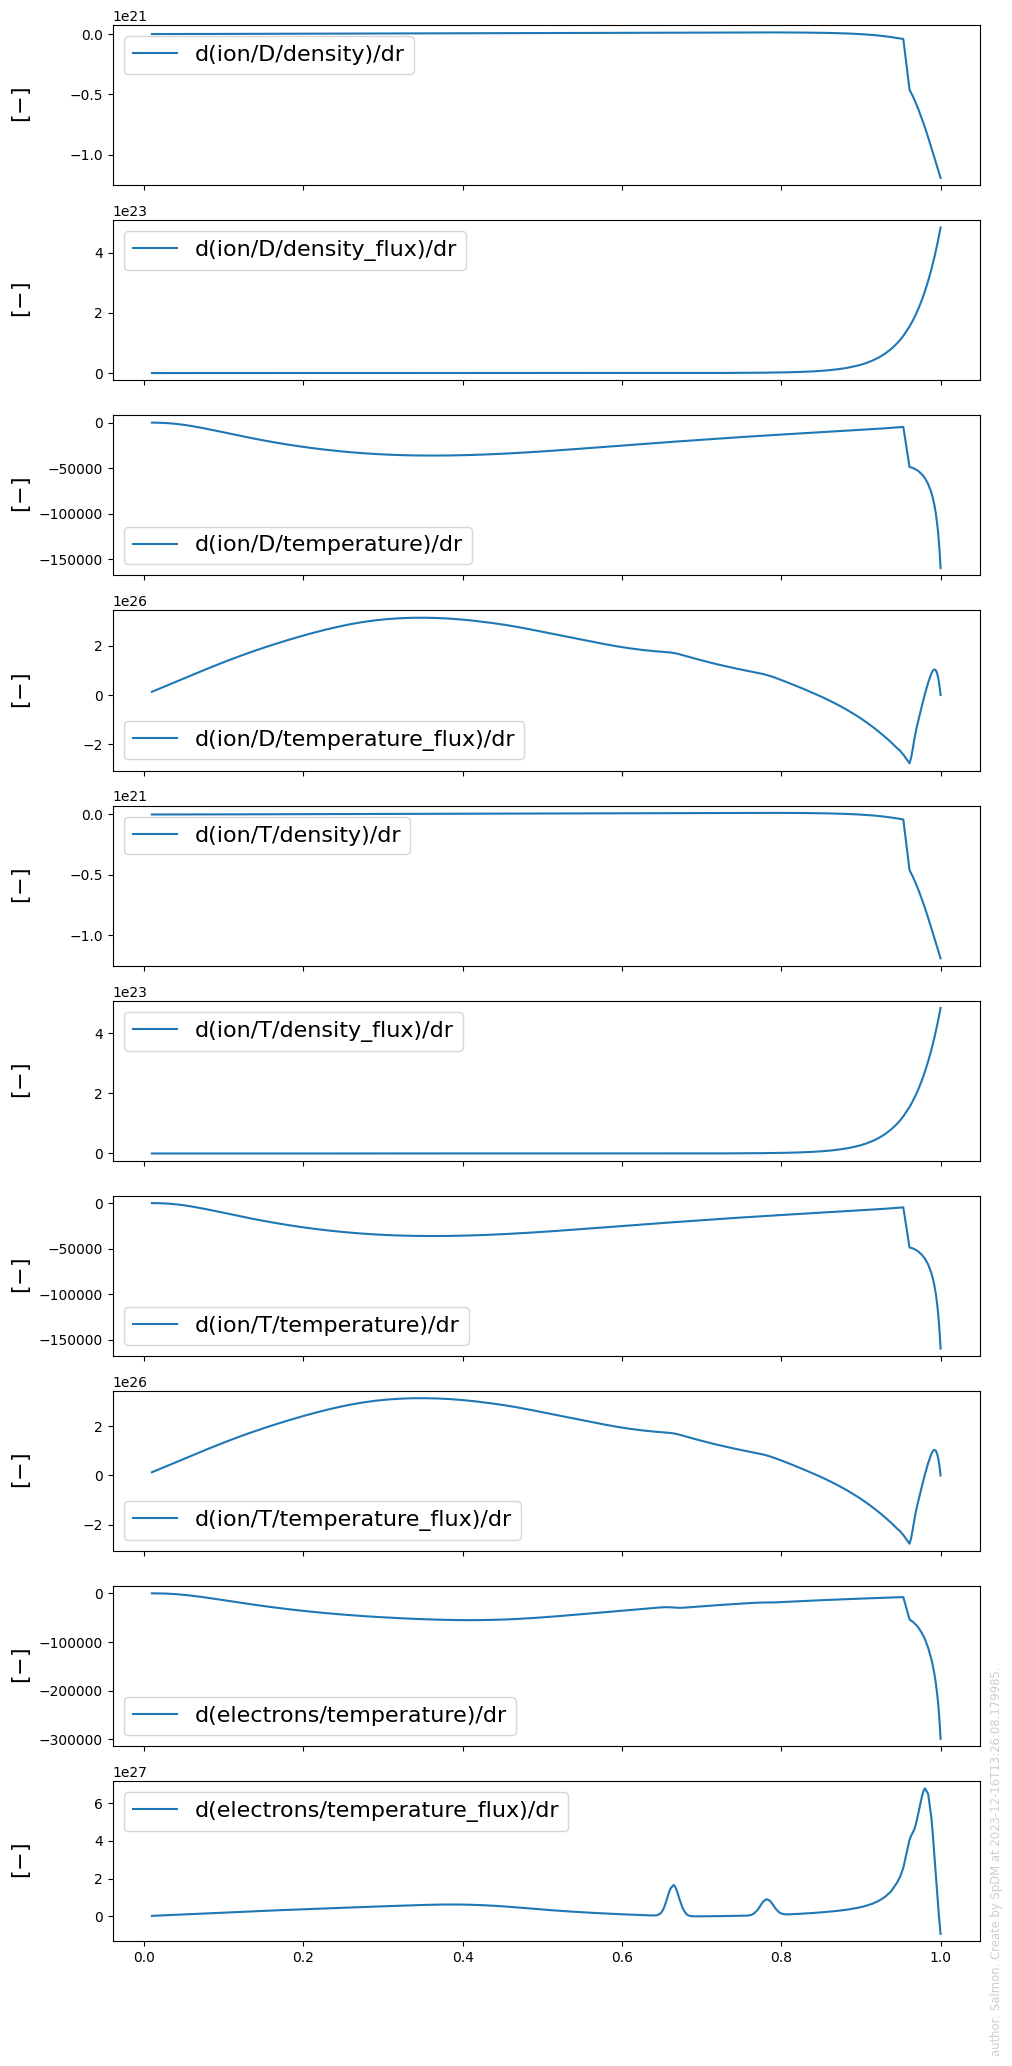

In [8]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    *sum(
        [
            [
                # (equ.profile, equ.identifier),
                # (equ.flux, f"{equ.identifier}_flux"),
                (equ.d_dr, f"d({equ.identifier})/dr"),
                (equ.dflux_dr, f"d({equ.identifier}_flux)/dr"),
            ]
            for equ in solver_1d.equations
        ],
        [],
    ),
)

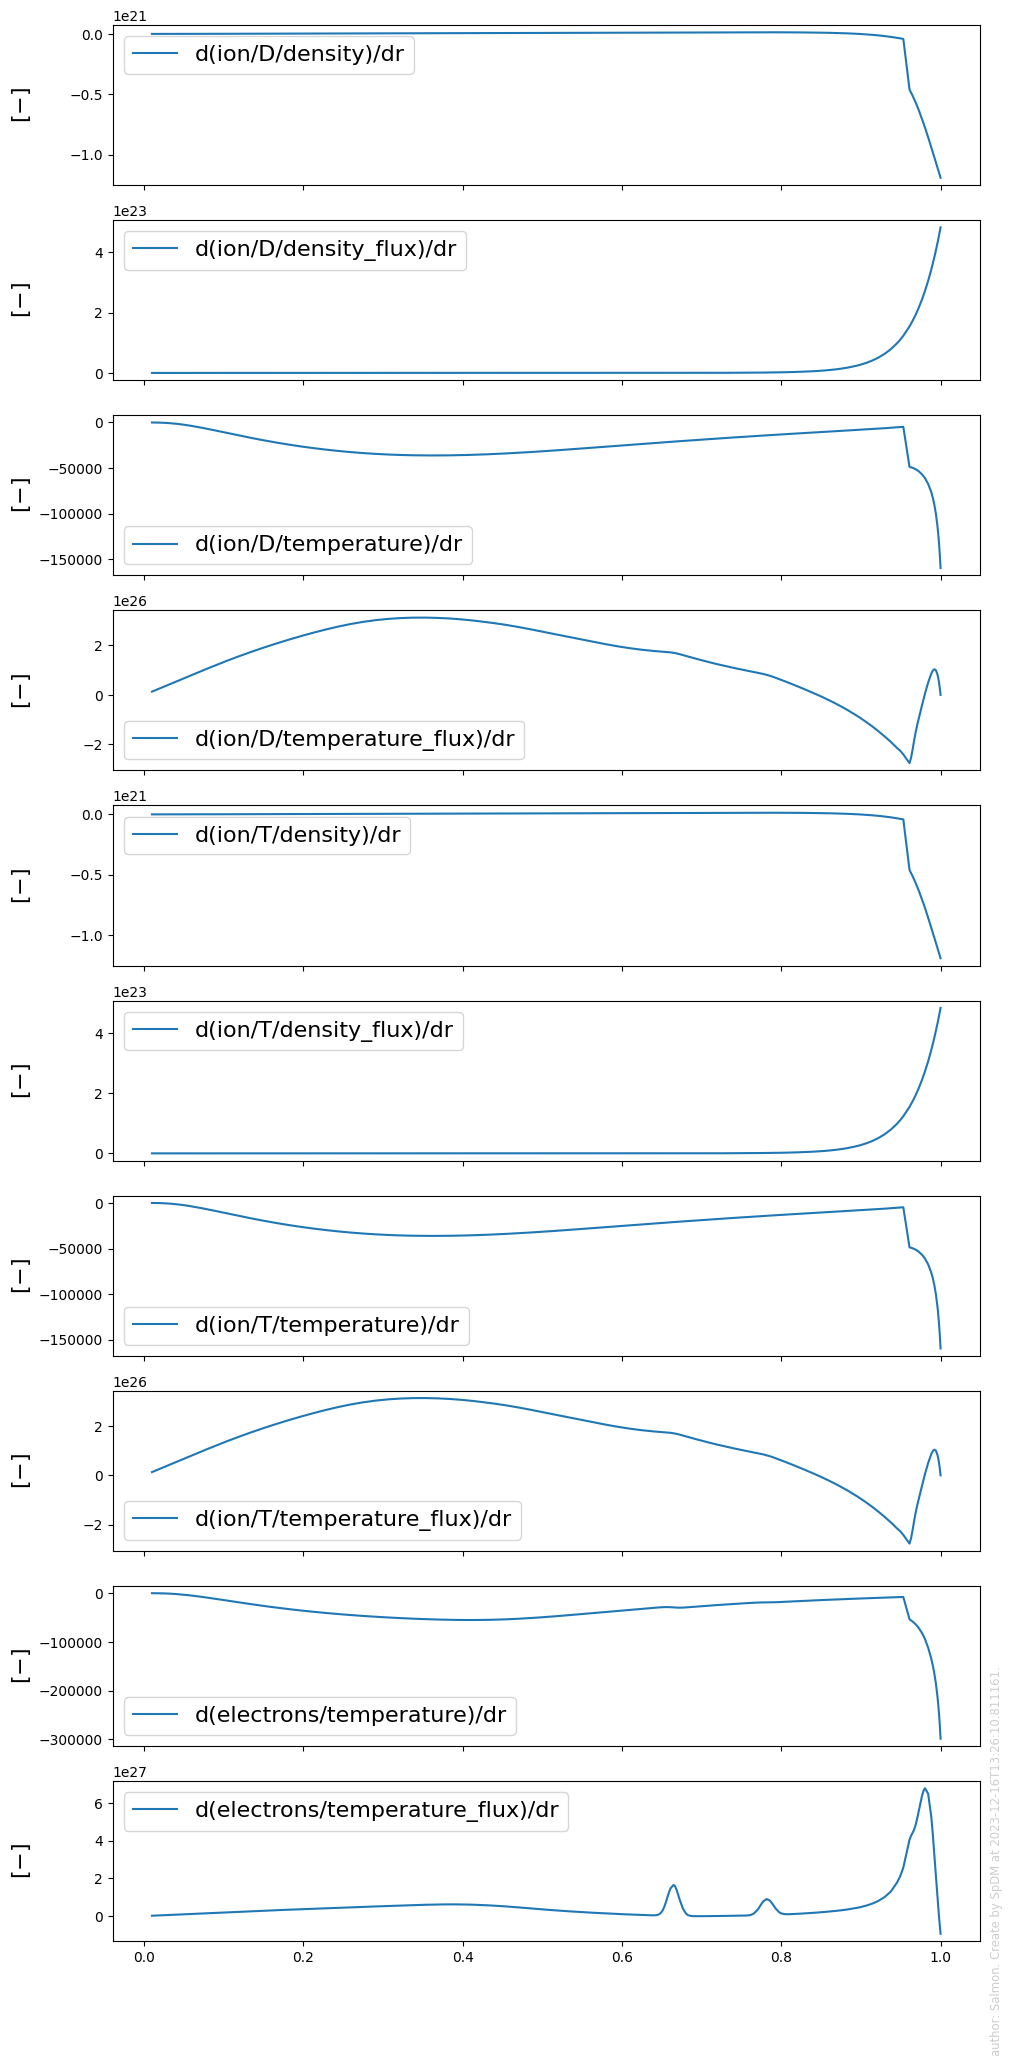

In [9]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    *sum(
        [
            [
                (equ.d_dr, f"d({equ.identifier})/dr"),
                (equ.dflux_dr, f"d({equ.identifier}_flux)/dr"),
            ]
            for equ in solver_1d.equations
        ],
        [],
    ),
)

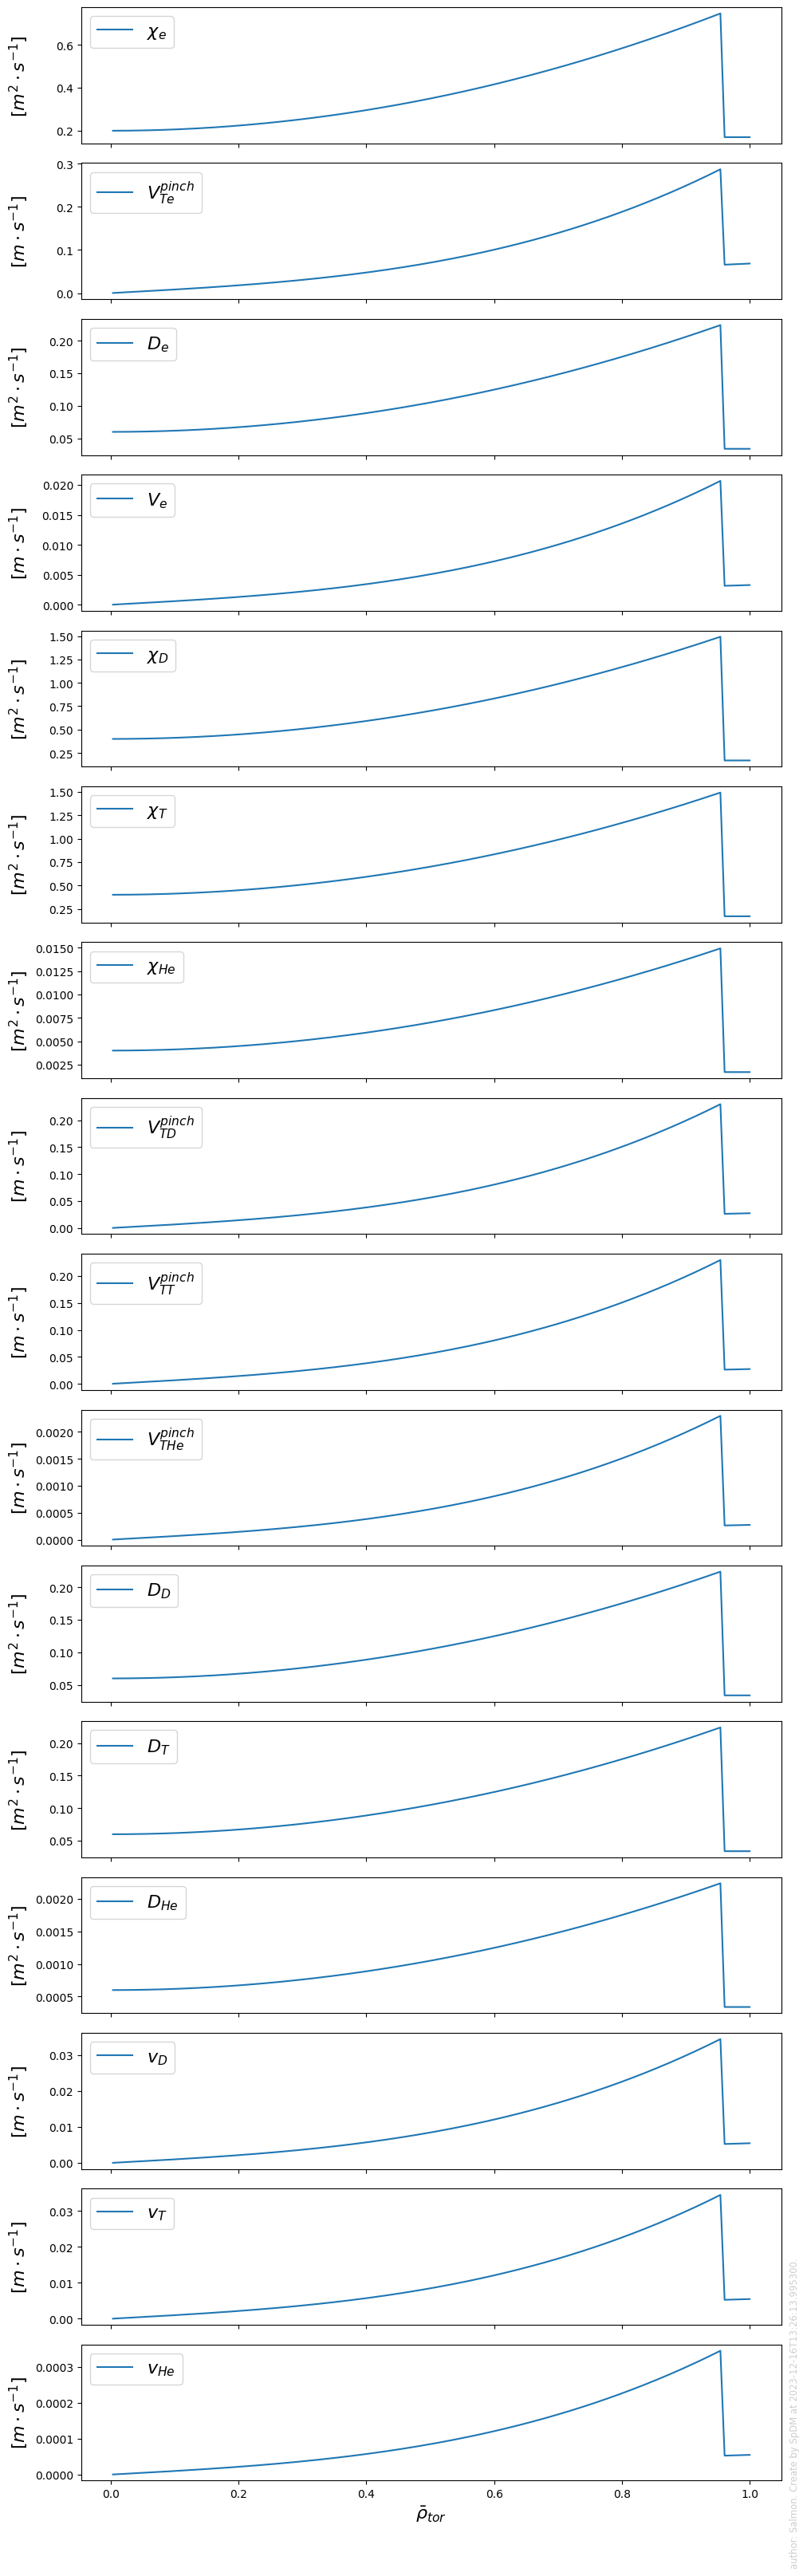

In [10]:
core_transport_1d = tokamak.core_transport.model[0].time_slice.current.profiles_1d

fig = sp_view.plot(
    core_transport_1d.grid_d.rho_tor_norm,
    (core_transport_1d.electrons.energy.d, r"$\chi_e$"),
    (core_transport_1d.electrons.energy.v, r"$V^{pinch}_{Te}$"),
    # (core_sources_1d.electrons.energy_decomposed.explicit_part, r"$Q_{e}$ explicit"),
    # (core_sources_1d.electrons.energy_decomposed.implicit_part, r"$Q_{e}$ implicit"),
    (core_transport_1d.electrons.particles.d, r"$D_e$"),
    (core_transport_1d.electrons.particles.v, r"$V_e$"),
    *[(ion.energy.d, rf"$\chi_{{{ion.label}}}$") for ion in core_transport_1d.ion],
    *[(ion.energy.v, rf"$V^{{pinch}}_{{T{ion.label}}}$") for ion in core_transport_1d.ion],
    *[(ion.particles.d, rf"$D_{{{ion.label}}}$") for ion in core_transport_1d.ion],
    *[(ion.particles.v, rf"$v_{{{ion.label}}}$") for ion in core_transport_1d.ion],
    x_label=r"$\bar{\rho}_{tor}$",
)

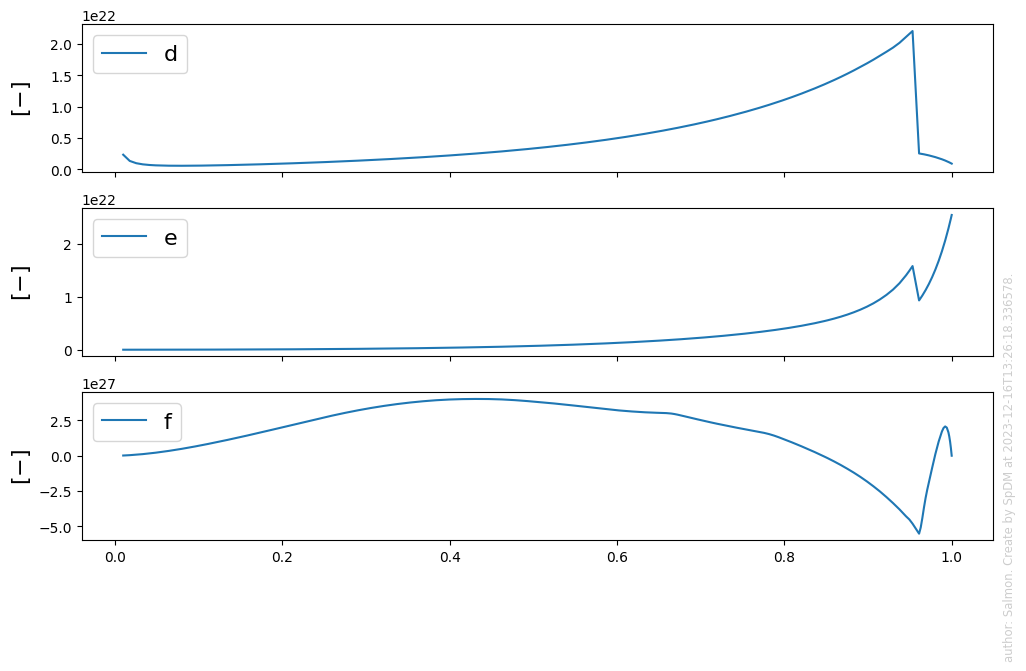

In [11]:
variables = sum([[equ.profile, equ.flux] for equ in solver_1d.equations], [])
equ = solver_1d.equations[1]
bc0,bc1, a, b, c, d, e, f, g,ym = equ.coefficient
x = solver_1d.grid.rho_tor_norm
# y = equ.profile
# yp = equ.d_dr
# flux = equ.flux
# dflux = equ.dflux_dr
fig = sp_view.plot(
    x,
    # (a(x, *variables), "a"),
    # (b(x, *variables), "b"),
    # (c(x,*vars), "c"),
    (d(x, *variables), "d"),
    (e(x, *variables), "e"),
    (f(x, *variables), "f"),
    # (g(x, *vars), "g"),
    # tokamak.transport_solver.equations[2].d_dr,
    # [
    #     (d*yp, "$D$"),
    #     (e*y,   "$v$"),
    #     # (flux,   f"$\Gamma$"),
    #     ((c*(f - g * y)).I, r"$S$"),  # $\int c*(f - g \cdot y)$
    #     # ((-d*yp+e*y).I, r"$\Gamma$"),
    #     (-d*yp+e*y-(c*(f - g * y)).I, "residual"),
    # ],
    # y, yp
    # [
    #     (dflux, {"label": r"$d\Gamma$"}),
    #     # (Function(flux, x).d(), r"$d\Gamma$"),
    #     ((c*(f - g * y)), r"$c*(f - g \cdot y)$"),
    # ],
)

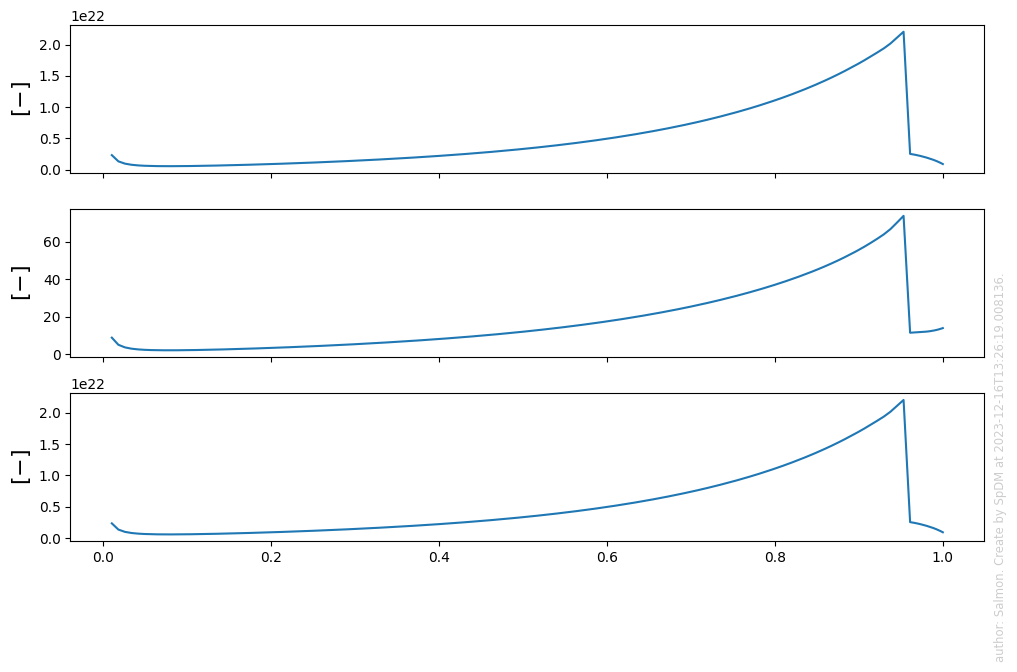

In [12]:
fig = sp_view.plot(
    x,
    solver_1d.equations[1].coefficient[5](x, *variables),
    solver_1d.equations[2].coefficient[5](x, *variables),
    solver_1d.equations[3].coefficient[5](x, *variables),
)